In [47]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# Hermite function convolution

What does it look like when I convolve a stellar spectrum with Hermite functions? Does it look anything like the changescaused by active regions?

### Hermite function evaluation

Firstwe need to evaluate hermite functions. This can be numerically tricky but luckily I found this <a href="https://www.numbercrunch.de/blog/2014/08/calculating-the-hermite-functions/#codesyntax_1">webpage</a> that provides a handy code snippet (note that I modified to correct a bug in the order 1 function and to avoid importing * from numpy):

In [48]:
def hermfunc(n, x):
    if n==0:
        return np.ones_like(x)*np.pi**(-0.25)*np.exp(-x**2/2)
    if n==1:
        return np.sqrt(2.)*x*np.pi**(-0.25)*np.exp(-x**2/2)
    h_i_2=np.ones_like(x)*np.pi**(-0.25)
    h_i_1=np.sqrt(2.)*x*np.pi**(-0.25)
    sum_log_scale=np.zeros_like(x)
    for i in range(2, n+1):
        h_i=np.sqrt(2./i)*x*h_i_1-np.sqrt((i-1.)/i)*h_i_2
        h_i_2, h_i_1=h_i_1, h_i
        log_scale=np.log(abs(h_i)).round()
        scale=np.exp(-log_scale)
        h_i=h_i*scale
        h_i_1=h_i_1*scale
        h_i_2=h_i_2*scale
        sum_log_scale+=log_scale
    res = h_i*np.exp(-x**2/2+sum_log_scale)
    res[~np.isfinite(res)]=0.0
    return res

Does it work?

0.7511251688271404 1.177117711771177


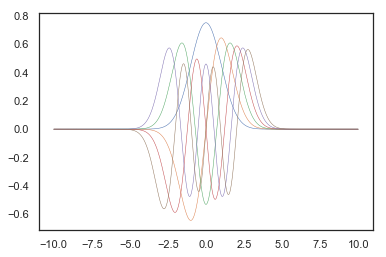

In [49]:
x = np.linspace(-10,10,10000)
for n in range(6):
    y = hermfunc(n, x)
    plt.plot(x,y,lw=0.5)
    if n==0:
        m = max(y)
        l = np.where(y>m/2)[0]
        print(m,0.5*(x[l[-1]]-x[l[0]]))


All looking good. Now let's convolve something with a Hermite function

In [50]:
from scipy.signal import convolve
from scipy.interpolate import interp1d
def hermite_convolve(x, y, n, sigma, norm = False):
    # define range over which to evaluate desired Hermite function
    fwhm_ref = 2.34
    xmin = -4 * fwhm_ref
    xmax = 4 * fwhm_ref
    # define sampling so that the step size is the same as in the input x-array
    dx = np.median(x[1:]-x[:-1]) / sigma
    nx_ = int((xmax - xmin) / dx)
    x_ = np.linspace(xmin, xmax, nx_)
    y_ = hermfunc(n, x_)
    z = convolve(y, y_, mode='same', method='auto')
    if norm:
        z /= max(abs(z))
    return z

So, now what do we do with this? I guess the simplest thing to try would be to model a time-series of pseudo-spectra (individual residuals from subtraction of some reference spectrum) a linear combination of the reference and the various Hermite functions. The reference can be a specific observed spectrum selected to be inactive (or probably better some kind of de-noise version thereof, like a GP fit) or simple the mean of all the spectra.

As a first relatively trivial test: can we reproduce a time-series of spectra with only actual Doppler shifts between them using the n=1 Hermite function? Let's take the simple simulated spectrum above and see (I'm going to assume the wavelength axis is log lambda already)

Right, so I can (more or less) reproduce the residuals by convolving the line list with a $n=1$ Hermite function whose width matches the line width, or by convolving the observed spectrum with a much narrower one. In practice I guess I will use the actual specturm since the line list is unknown in real life, and with leave the width of the Hermite functions as a free parameter. 

In [51]:
import numpy, sys
import scipy.linalg, scipy.special

'''
VBLinRegARD: Linear basis regression with automatic relevance priors
using Variational Bayes.

For more details on the algorithm see Apprendix of
Roberts, McQuillan, Reece & Aigrain, 2013, MNRAS, 354, 3639.

History:
2011: Translated by Thomas Evans from original Matlab code by Stephen J Roberts
2013: Documentation added by Suzanne Aigrain
'''

def logdet(a):
    '''
    Compute log of determinant of matrix a using Cholesky decomposition
    '''
    # First make sure that matrix is symmetric:
    if numpy.allclose(a.T,a) == False:
        print('MATRIX NOT SYMMETRIC')
    # Second make sure that matrix is positive definite:
    eigenvalues = scipy.linalg.eigvalsh(a)
    if min(eigenvalues) <=0:
        print('Matrix is NOT positive-definite')
        print('   min eigv = %.16f' % min(eigenvalues))     
    step1 = scipy.linalg.cholesky(a)
    step2 = numpy.diag(step1.T)
    out = 2. * numpy.sum(numpy.log(step2), axis=0)
    return out

def bayes_linear_fit_ard(X, y):
    '''
    Fit linear basis model with design matrix X to data y.
    
    Calling sequence:
    w, V, invV, logdetV, an, bn, E_a, L = bayes_linear_fit_ard(X, y)
    
    Inputs:
    X: design matrix
    y: target data
    
    Outputs
    w: basis function weights
    ***need to document the others!***
    '''
    # uninformative priors
    a0 = 1e-2
    b0 = 1e-4
    c0 = 1e-2
    d0 = 1e-4
    # pre-process data
    [N, D] = X.shape
    X_corr = X.T * X
    Xy_corr = X.T * y    
    an = a0 + N / 2.    
    gammaln_an = scipy.special.gammaln(an)
    cn = c0 + 1 / 2.    
    D_gammaln_cn = D * scipy.special.gammaln(cn)
    # iterate to find hyperparameters
    L_last = -sys.float_info.max
    max_iter = 500
    E_a = numpy.matrix(numpy.ones(D) * c0 / d0).T
    for iter in range(max_iter):
        # covariance and weight of linear model
        invV = numpy.matrix(numpy.diag(numpy.array(E_a)[:,0])) + X_corr   
        V = numpy.matrix(scipy.linalg.inv(invV))
        logdetV = -logdet(invV)    
        w = numpy.dot(V, Xy_corr)[:,0]
        # parameters of noise model (an remains constant)
        sse = numpy.sum(numpy.power(X*w-y, 2), axis=0)
        if numpy.imag(sse)==0:
            sse = numpy.real(sse)[0]
        else:
            print('Something went wrong')
        bn = b0 + 0.5 * (sse + numpy.sum((numpy.array(w)[:,0]**2) * numpy.array(E_a)[:,0], axis=0))
        E_t = an / bn 
        # hyperparameters of covariance prior (cn remains constant)
        dn = d0 + 0.5 * (E_t * (numpy.array(w)[:,0]**2) + numpy.diag(V))
        E_a = numpy.matrix(cn / dn).T
        # variational bound, ignoring constant terms for now
        L = -0.5 * (E_t*sse + numpy.sum(scipy.multiply(X,X*V))) + \
            0.5 * logdetV - b0 * E_t + gammaln_an - an * scipy.log(bn) + an + \
            D_gammaln_cn - cn * numpy.sum(scipy.log(dn))
        # variational bound must grow!
        if L_last > L:
            # if this happens, then something has gone wrong....
            file = open('ERROR_LOG','w')
            file.write('Last bound %6.6f, current bound %6.6f' % (L, L_last))
            file.close()
            raise Exception('Variational bound should not reduce - see ERROR_LOG')
            return
        # stop if change in variation bound is < 0.001%
        if abs(L_last - L) < abs(0.00001 * L):        
            break
        # print L, L_last
        L_last = L
    if iter == max_iter:    
        warnings.warn('Bayes:maxIter ... Bayesian linear regression reached maximum number of iterations.') 
    # augment variational bound with constant terms
    L = L - 0.5 * (N * numpy.log(2 * numpy.pi) - D) - scipy.special.gammaln(a0) + \
        a0 * numpy.log(b0) + D * (-scipy.special.gammaln(c0) + c0 * numpy.log(d0))
    return w, V, invV, logdetV, an, bn, E_a, L

In [52]:

def fit_basis(y_obs, basis, scl = None):
    '''
    weights = fit_basis(flux, basis, scl = None)
    fit VB linear basis model to K observed time_series each containing N observations

    Inputs:
        flux: (K,N) light curve(s) 
        basis: (B,N) basis trends
        scl: (B,) prior scaling factors for the basis trends
    Outputs:
        weights: (K,B) weights
    '''
    # pre-process basis
    B, N = basis.shape
    Basis = numpy.matrix(basis.T)
    if scl == None: scl = numpy.ones(B)
    Bnorm = numpy.multiply(Basis, scl)
    Bs = Bnorm.std()
    Bnorm /= Bs
    Bnorm = numpy.concatenate((Bnorm, numpy.ones((N,1))), axis=1)
    # array to store weights
    K = y_obs.shape[0]
    weights = numpy.zeros((K,B))
    for k in numpy.arange(K): 
        # pre-process observed ys
        Y = numpy.matrix(y_obs[k,:]).T
        l = numpy.isfinite(Y)
        Ym = Y[l].mean()
        Ys = Y[l].std()
        Ynorm = (Y - Ym) / Ys
        w, V, invV, logdetV, an, bn, E_a, L = bayes_linear_fit_ard(Bnorm, Ynorm)
        weights[k,:] = numpy.array(w[:-1]).flatten() * scl * Ys / Bs
    return weights

def apply_basis(weights, basis):
    '''
    model = apply_basis(weights, basis) 
    Compute linear basis model given weights and basis matrix

    Inputs:
        weights: (K,B) weights
        basis: (B,N) basis trends
    Outputs:
        corr: (K,N) correction to apply to observed y's
    '''
    return numpy.dot(weights, basis)

In [53]:
def fit_herm(xs, ys, yd, B, sig=0.1, yref = None):
    K,N = xs.shape
    fig, axes = plt.subplots(3, 1, sharex = True, figsize=(10,10))
    if yref is None:
        yref = ys[0,:]
    for k in range(K):
        yc = ys[k,:]
        xc = xs[k,:]
        if k == 0:
            axes[0].plot(xc, yd, 'b-',lw=0.5,alpha=0.5)
        axes[0].plot(xc, yc, 'k-',lw=0.5,alpha=0.5)
        axes[1].plot(xc, yc - yref,'k-',lw=0.5,alpha=0.5)
        basis = np.ones((B,N))
        for b in range(B):
            basis[b,:] = hermite_convolve(xc, yd, b, sig, norm=True)
        w = fit_basis(yc.reshape((1,N)), basis)
        print(w)
        corr = apply_basis(w, basis).flatten()
#        plt.figure()
#        plt.plot(xc,yc)
#        plt.plot(xc,corr)
#        plt.plot(xc,yc-corr)
        axes[0].plot(xc, corr,'r-',lw=0.5,alpha=0.5)
        axes[1].plot(xc, corr- yref,'r-',lw=0.5,alpha=0.5)
        axes[2].plot(xc, yc-corr,'k-',lw=0.5,alpha=0.5)
        


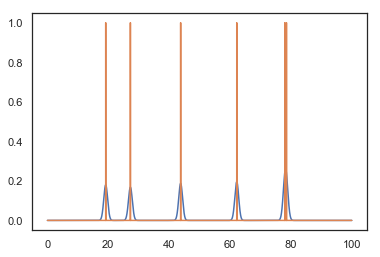

In [54]:
np.random.seed(1234)
x = np.linspace(0,100,10000)
y = np.zeros_like(x)
yy = np.zeros_like(x)
L = 6
mu = np.random.uniform(x.min(),x.max(),L)
sig = np.random.uniform(0.3,1.5,1)
a = np.random.uniform(0.1,0.2,L)
for l in range(L):
    y += a[l] * np.exp( - (x - mu[l])**2 / 2 / sig**2)
    ll = np.argmin(abs(x-mu[l]))
    yy[ll] = 1
plt.plot(x, y)
plt.plot(x,yy)

(55, 70)

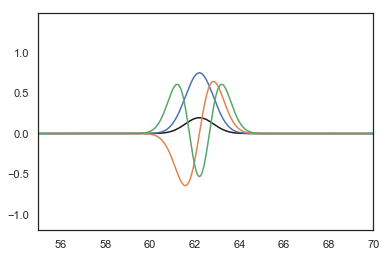

In [55]:
plt.plot(x, y, 'k-')
for n in range(3):
    z = hermite_convolve(x, yy, n, sig)
    plt.plot(x, z)
#plt.ylim(0.99,1.01)
plt.xlim(55,70)

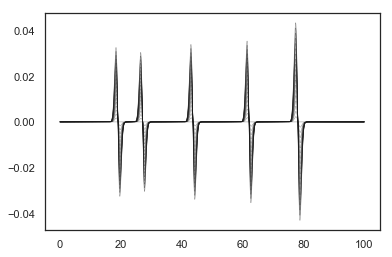

In [56]:
from scipy.interpolate import interp1d
N = len(y)
K = 20
shifts = np.arange(K)*0.01
ys = np.zeros((K,N))
xs = np.zeros((K,N))
g = interp1d(x,y,fill_value=0,bounds_error=False)
for k in range(K):
    xx = x + shifts[k]
    xs[k,:] = x
    ys[k,:] = g(xx)
    plt.plot(x,ys[k,:]-y,'k-',alpha=0.5,lw=0.5)

[[ 0.30658709 -0.00115115 -0.04544176]]
[[ 0.14829055 -0.00345282  0.11280119]]
[[-0.16825425 -0.00575325  0.42923882]]
[[-0.64279761 -0.00805165  0.90362151]]
[[-1.27496184 -0.01034719  1.53557164]]
[[-2.06428762 -0.01263906  2.32462998]]
[[-3.0101944  -0.01492644  3.27021614]]
[[-4.11198591 -0.01720854  4.37163397]]
[[-5.3688513  -0.01948453  5.62807284]]
[[-6.77986593 -0.02175363  7.03860829]]
[[-8.34399215 -0.02401503  8.60220292]]
[[-10.06008048  -0.02626794  10.31770751]]
[[-11.92687022  -0.02851158  12.18386163]]
[[-13.94299145  -0.03074515  14.19929568]]
[[-16.10696488  -0.03296788  16.36253071]]
[[-18.41720465  -0.03517901  18.6719812 ]]
[[-20.87201857  -0.03737777  21.12595537]]
[[-23.46961063  -0.03956339  23.7226576 ]]
[[-26.2080817   -0.04173514  26.46018919]]
[[-29.08543219  -0.04389228  29.33655101]]


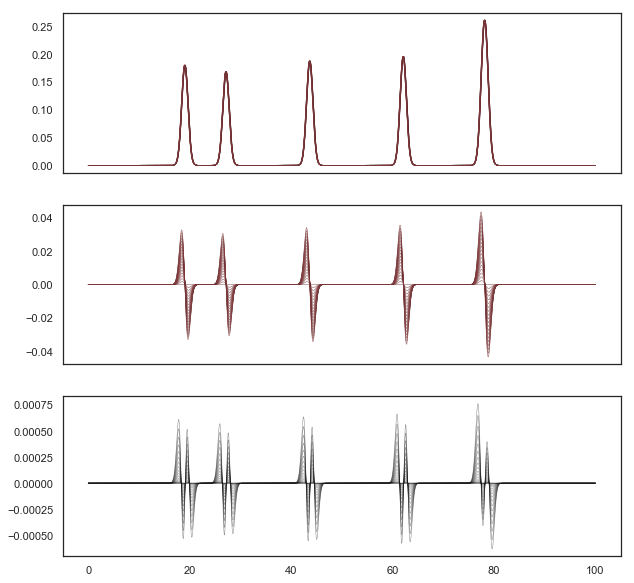

In [57]:
fit_herm(xs, ys, y, 3, 0.01)

So it kind of works but I think I would get better results by modelling the spectra as a linear combination of the reference sectrum and its derivatives, rather than actual Hermite functions, because when using Hermite functions I have to either know where the lines are or if I'm convolving the observed reference with Hermite functions I'm actually broadening it I'm left with these (admittedly small) residuals.

If I fit the reference spectrum with a GP evaluating the derivatives is trivial. For now since I am working with a noise-free sim I'll just use first differences to estimate the derivatives.

In [58]:
def fit_deriv(x, ys, B):
    K,N = ys.shape
    fig, axes = plt.subplots(3, 1, sharex = True, figsize=(10,10))
    basis = np.ones((B,N))
    yc = ys[0,:]
    dx = x[1] - x[0]
    basis[0,:] = yc
    for b in range(B-1):
        dy = yc[1:] - yc[:-1]
        g = interp1d(x[:-1]+0.5*dx,dy,bounds_error=False,fill_value=0)
        yc = g(x)
        m = abs(yc).max()
        basis[b+1,:] = yc/m
    ws = np.zeros((B,K))
    for k in range(K):
        yc = ys[k,:]
        axes[0].plot(x, yc, 'k-',lw=0.5,alpha=0.5)
        axes[1].plot(x, yc - ys[0,:],'k-',lw=0.5,alpha=0.5)
        w = fit_basis(yc.reshape((1,N)), basis)
        ws[:,k] = w
        corr = apply_basis(w, basis).flatten()
        axes[0].plot(x, corr,'r-',lw=0.5,alpha=0.5)
        axes[1].plot(x, corr - ys[0,:],'r-',lw=0.5,alpha=0.5)
        axes[2].plot(x, yc-corr,'k-',lw=0.5,alpha=0.5)
    return ws    


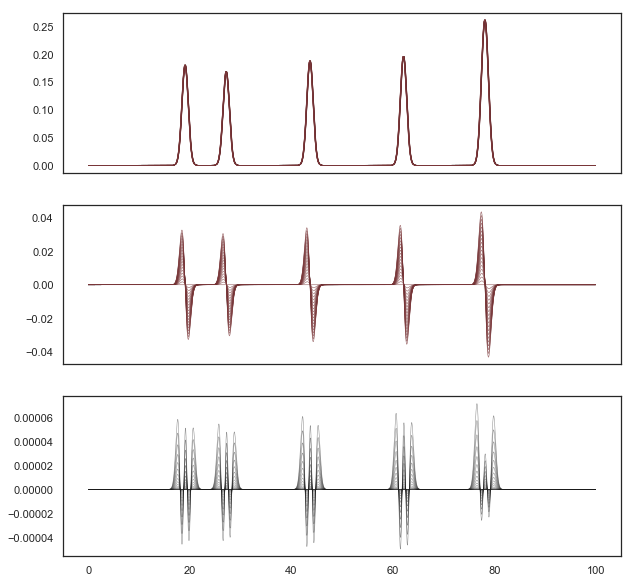

In [59]:
ws=fit_deriv(x, ys, 4)

So that seems to work even better: residuals are smaller by orderof magnitude. Now what happens if I generate a time series with width as well a rv changes?

(55, 70)

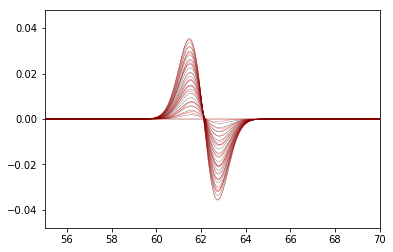

In [14]:
np.random.seed(1234)
x = np.linspace(0,100,10000)
y = np.zeros_like(x)
yy = np.zeros_like(x)
L = 6
mu = np.random.uniform(x.min(),x.max(),L)
sig = np.random.uniform(0.3,1.5,1)
a = np.random.uniform(0.1,0.2,L)
K = 20
shifts = np.arange(K)*0.01
dsig = np.append(0,np.random.uniform(-0.01,0.01,K-1))
ys1 = np.zeros((K,N))
ys2 = np.zeros((K,N))
for k in range(K):
    xx = x + shifts[k]
    sigc = sig + dsig[k]
    for l in range(L):
        ys1[k,:] += a[l] * np.exp( - (xx - mu[l])**2 / 2 / sig**2)
        ys2[k,:] += a[l] * np.exp( - (xx - mu[l])**2 / 2 / sigc**2)
    plt.plot(x, ys1[k,:]-ys1[0,:],'k-',lw=0.5,alpha=0.5)
    plt.plot(x, ys2[k,:]-ys1[0,:],'r-',lw=0.5,alpha=0.5)
    
plt.xlim(55,70)

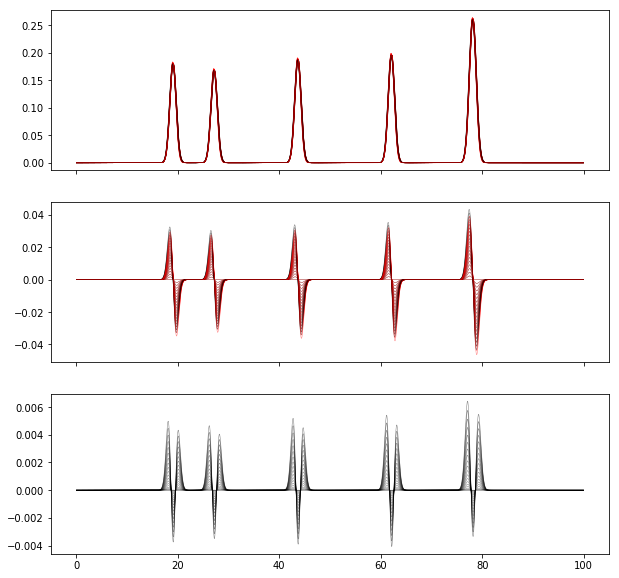

In [15]:
w1=fit_deriv(x, ys1, 2)

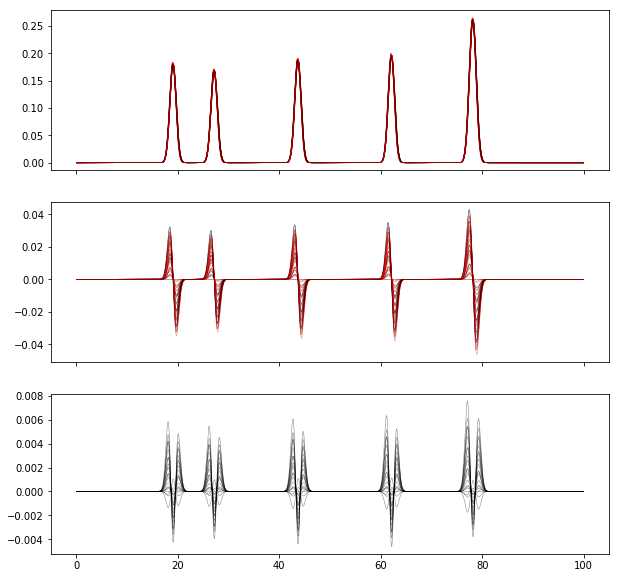

In [16]:
w2=fit_deriv(x, ys2, 2)

In [17]:
for k in range(K):
    print(w1[1,k],w2[1,k],w2[1,k]-w1[1,k])


2.781161920191428e-17 2.781161920191428e-17 0.0
0.0023020826154331723 0.0022955289817407315 -6.553633692440823e-06
0.004603347766698681 0.004611194657282927 7.846890584245828e-06
0.006902978357446594 0.0068973901953726675 -5.5881620739262755e-06
0.009200158330899688 0.00919978425502368 -3.740758760077678e-07
0.011494073097801738 0.01156639154741679 7.231844961505182e-05
0.013783909987543995 0.01373399394689558 -4.991604064841573e-05
0.016068858758228746 0.015987095929452636 -8.176282877610935e-05
0.018348112069251122 0.01838043548552494 3.232341627381827e-05
0.020620865958852132 0.020589641462479005 -3.1224496373126465e-05
0.02288632031879045 0.023011084348925265 0.0001247640301348142
0.025143679365783066 0.025186352720281125 4.2673354498059396e-05
0.027392152109315296 0.027236136341270232 -0.00015601576804506398
0.02963095281546563 0.029572727719560946 -5.8225095904685525e-05
0.031859301466353546 0.03190127699644889 4.197553009534227e-05
0.03407642421482798 0.03394908564286669 -0.0001

To apply the Hermite function convolution approach to spectra I'd need to know where the lines are. On the other hand, using the derivative doesn't require any prior knowledge of the line locations or other properties.

Let's have a go at a set of real HARPS spectra. I have some AU Mic observations on hand, with quite significant activity-induced effects.

In [18]:
import HARPS_utils as Hu
sd = Hu.test_2d()

Found 45 e2ds files in directory /Data/HARPS_Grenoble/AU_Mic/DRS_spectra
Will look for blaze files in directory /Data/HARPS_Grenoble/AU_Mic/DRS_spectra
Processing e2ds file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2003-12-13T00-24-50.450_e2ds_A.fits.
Blaze file name in headeris HARPS.2003-12-12T21:42:45.093_blaze_A.fits
Found blaze file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2003-12-12T21?42?45.093_blaze_A.fits.
Processing e2ds file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2004-06-01T09-21-32.253_e2ds_A.fits.
Blaze file name in headeris HARPS.2004-05-31T21:54:04.588_blaze_A.fits
Found blaze file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2004-05-31T21?54?04.588_blaze_A.fits.
Processing e2ds file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2004-07-15T07-30-38.982_e2ds_A.fits.
Blaze file name in headeris HARPS.2004-07-14T21:38:56.983_blaze_A.fits
Found blaze file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2004-07-14T21?38?56.983_blaze_A.fits.
Processing e2ds file

Blaze file name in headeris HARPS.2016-07-20T21:18:47.435_blaze_A.fits
Found blaze file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2016-07-20T21?18?47.435_blaze_A.fits.
Processing e2ds file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2017-05-31T07-11-10.106_e2ds_A.fits.
Blaze file name in headeris HARPS.2017-05-30T18:58:25.729_blaze_A.fits
Found blaze file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2017-05-30T18?58?25.729_blaze_A.fits.
Processing e2ds file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2017-05-31T07-26-41.738_e2ds_A.fits.
Blaze file name in headeris HARPS.2017-05-30T18:58:25.729_blaze_A.fits
Found blaze file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2017-05-30T18?58?25.729_blaze_A.fits.
Processing e2ds file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2017-06-13T09-04-31.319_e2ds_A.fits.
Blaze file name in headeris HARPS.2017-06-12T21:12:48.608_blaze_A.fits
Found blaze file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2017-06-12T21?12?48.608_blaze_A.fits.


Reading spectrum 39 from file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2017-10-10T23-50-25.261_e2ds_A.fits
Reading spectrum 40 from file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2018-03-29T08_44_26.753_e2ds_A.fits
Reading spectrum 41 from file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2018-03-29T08_59_57.464_e2ds_A.fits
Reading spectrum 42 from file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2018-03-30T09_12_59.029_e2ds_A.fits
Reading spectrum 43 from file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2018-03-30T09_28_30.541_e2ds_A.fits
Reading spectrum 44 from file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2018-03-31T09_02_29.762_e2ds_A.fits
Reading spectrum 45 from file /Data/HARPS_Grenoble/AU_Mic/DRS_spectra/HARPS.2018-03-31T09_18_00.434_e2ds_A.fits


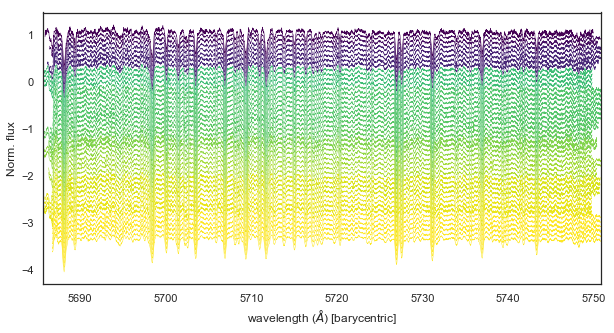

In [19]:
Hu.plot_2d(sd, snr_range = [30, 10000], orders = [53])

Select a small wavelength region to work with

In [20]:
wav = sd["wav_bary"]
flux =  sd["flux_norm"]
snr = sd['snr']
bjd = sd['bjd']
baryvel = sd['baryvel']
order = 53
snr_min = 30
l = snr >= snr_min
bjd = bjd[l]
baryvel = baryvel[l]
snr = snr[l]
wav = wav[l, order, :]
flux = flux[l, order, :]

In [21]:
wmin, wmax = 5725, 5735
l = (wav[0,:] >= wmin) * (wav[0,:] <= wmax)
wav = wav[:,l]
flux = flux[:,l]

Interpolate all of the spectra to the same wavelength grid

In [22]:
K, N = wav.shape
lwav = np.log(wav * 1e-10) # wavelengths are in Angstrom
lwmin,lwmax = lwav.min(),lwav.max()
x = np.linspace(0,100,10000)
ys = np.zeros((K,len(x)))
xmin = 0
xmax = 100
for k in range(K):
    yc = flux[k,:]-1
    lwc = lwav[k,:]
    xc = 100*(lwc-lwmin)/(lwmax-lwmin)
    xmin = max(xmin, xc.min())
    xmax = min(xmax, xc.max())
    g = interp1d(xc,yc,bounds_error=False,fill_value=0)
    ys[k,:] = g(x)
l = (x >= xmin) * (x <= xmax)
x = x[l]
ys = ys[:,l]

Do the fit

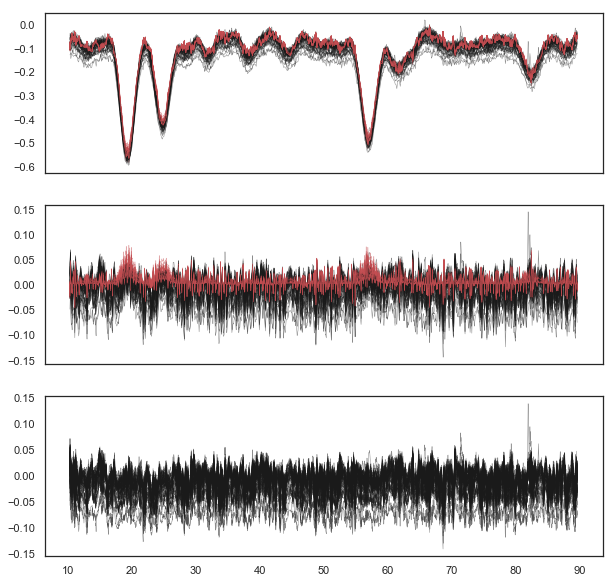

In [23]:
w = fit_deriv(x, ys, 4)

In [24]:
print(w.T)

[[ 1.00000000e+00  4.38187774e-15 -1.99414498e-13  2.64103242e-15]
 [ 9.37105985e-01 -1.75292761e-04  4.42436119e-02  1.03861080e-04]
 [ 9.56375640e-01  2.01136253e-03  4.70257945e-02  1.29759172e-03]
 [ 9.70211996e-01  5.51138654e-03  4.49847616e-02  4.56243276e-03]
 [ 9.82830621e-01  6.30525212e-03  4.79089021e-02  5.36971635e-03]
 [ 9.63317701e-01  8.98911358e-03  4.52452447e-02  7.61655368e-03]
 [ 9.77552910e-01  2.19798021e-03  4.67853599e-02  1.41747423e-03]
 [ 9.65926779e-01 -1.21131203e-03  4.74972141e-02 -6.76371916e-04]
 [ 9.50077534e-01  2.73712162e-03  4.51312911e-02  1.94229483e-03]
 [ 9.47748764e-01  1.47712919e-03  4.62209622e-02  1.05474197e-03]
 [ 9.55022355e-01 -2.64417436e-03  4.53579001e-02 -1.81542007e-03]
 [ 9.39315471e-01 -4.21531131e-03  4.55357769e-02 -3.61684981e-03]
 [ 9.40338595e-01  3.22473660e-03  4.39107176e-02  2.34373955e-03]
 [ 9.69511059e-01  4.14120020e-03  4.66993750e-02  3.44266854e-03]
 [ 9.59241150e-01  1.52875912e-03  4.56979946e-02  6.41344229e

In [45]:
from george import kernels, GP
from scipy.optimize import minimize
def fit_deriv_GP(x, ys, B):
    K,N = ys.shape
    fig, axes = plt.subplots(3, 1, sharex = True, figsize=(10,10))
    basis = np.ones((B,N))
    yc = ys[0,:]
#    xmin, xmax = x.min(), x.max()
#    x100 = (x - xmin) / (xmax - xmin)
#    k = 1.0 * kernels.Matern52Kernel(1.0)
#    gp = GP(k)
#    p2p = np.median(abs(yc[1:]-yc[:-1]))
#    gp.compute(x100[::10], yerr = p2p)
#    def nll(p):
#        gp.set_parameter_vector(p)
#        try:
#            gp.compute(x100[::10],yerr=p2p)
#        except:
#            return 1e20
#        return -gp.log_likelihood(yc[::10])
#    p0 = gp.get_parameter_vector()
#    soln = minimize(nll,p0)
#    print(soln.x)
#    gp.set_parameter_vector(soln.x)
#    gp.compute(x100,yerr=p2p)
#    ym = gp.predict(yc, x100,return_cov=False,return_var=False)
    ym = ys.mean(axis=0)
    dx = x[1] - x[0]
    basis[0,:] = ym[:]
    for b in range(B-1):
        dy = yc[1:] - yc[:-1]
        g = interp1d(x[:-1]+0.5*dx,dy,bounds_error=False,fill_value=0)
        yc = g(x)
        m = abs(yc).max()
        basis[b+1,:] = yc/m
    ws = np.zeros((B,K))
    for k in range(K):
        yc = ys[k,:]
        axes[0].plot(x, yc, 'k-',lw=0.5,alpha=0.5)
        axes[1].plot(x, yc - ys[0,:],'k-',lw=0.5,alpha=0.5)
        w = fit_basis(yc.reshape((1,N)), basis)
        ws[:,k] = w
        corr = apply_basis(w, basis).flatten()
        axes[0].plot(x, corr,'r-',lw=0.5,alpha=0.5)
        axes[1].plot(x, corr - ys[0,:],'r-',lw=0.5,alpha=0.5)
        axes[2].plot(x, yc-corr,'k-',lw=0.5,alpha=0.5)
    return ws    


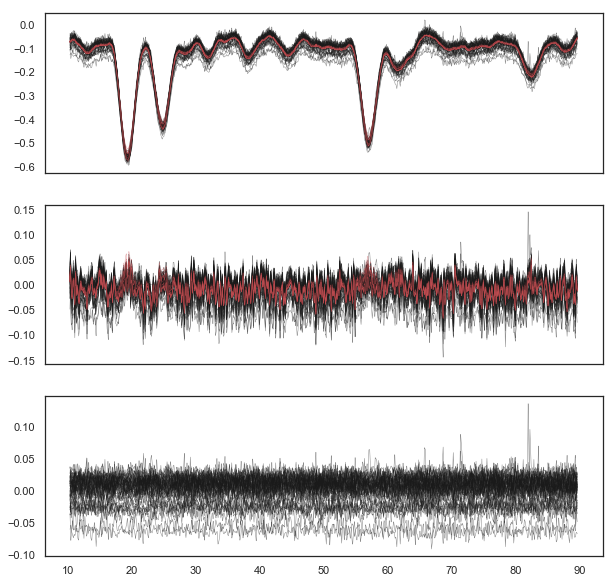

In [46]:
w = fit_deriv_GP(x, ys, 2)